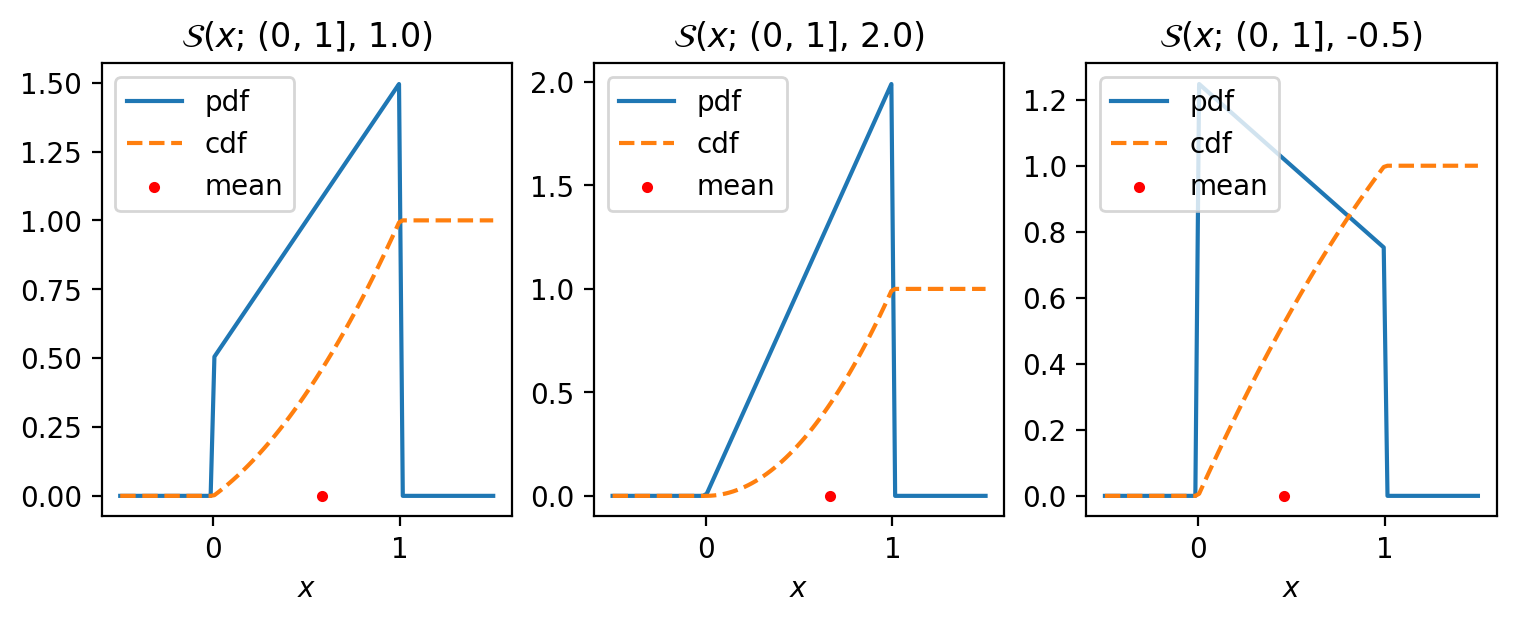

In [35]:
import sys
import spnhelp
import lgpgm
from spn.structure.leaves.parametric.Parametric import Gaussian, Uniform
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from spn.algorithms.Inference import likelihood
import matplotlib.pyplot as plt
from spn.structure.Base import get_number_of_nodes, Node, Sum, Product, Leaf

sd = 0.1
mean = 0.5

def slopyform_mean (node : spnhelp.Slopyform):
    a, b, s = node.start, node.end, node.slope
    t1 = a - b
    t2 = t1 ** 2
    return(-s * t2 * t1 / 12 + a / 2 + b / 2)

def slopyform_CDF(node : spnhelp.Slopyform, x) -> float:
    def cdf (x, a, b, s):
        if x <= a:
            s1 = 0
        elif b <= x:
            s1 = 1
        else:
            s1 = (s * (b - x) * a + 2 - b * (b - x) * s) * (a - x) / (-2 * b + 2 * a)
        return(s1)
    return cdf(x, node.start, node.end, node.slope)

def SPN_cdf(SPN : Node, x):
    if isinstance(SPN, Sum):
        return sum([w * SPN_cdf(child, x) for w, child in zip(SPN.weights, SPN.children)])
    elif isinstance(SPN, Product):
        return None
    elif isinstance(SPN, Leaf):
        if isinstance(SPN, spnhelp.Slopyform):
            return slopyform_CDF(SPN, x)
        else:
            raise Exception("Unknown leaf type")

def slopyform_INT(node : spnhelp.Slopyform, l:float, u:float) -> float:
    a, b, s = node.start, node.end, node.slope
    t6 = a - b
    if u < l:
        raise ValueError(f"upper bound of integration {u} is less than lower bound {l}") 
    elif b < l or u < a: 
        return 0.0
    
    u = min(u, b)
    l = max(l, a)

    if l == a and b == u:
        return 1.0
    else:
        return 1 / t6 * (2 + s * (a - l - u + b) * t6) * (l - u) / 2

def SPN_INT(SPN : Node, l:float, u:float):
    if isinstance(SPN, Sum):
        return sum([w * SPN_INT(child, l,u) for w, child in zip(SPN.weights, SPN.children)])
    elif isinstance(SPN, Product):
        return None
    elif isinstance(SPN, Leaf):
        if isinstance(SPN, spnhelp.Slopyform):
            return slopyform_INT(SPN, l,u)
        else:
            raise Exception("Unknown leaf type")


bounds = [[0,1], [0,1], [0,1]]
slopes = [1.0, 2.0, -0.5]

plt.rcParams["figure.figsize"] = (3*len(slopes),3)
plt.rcParams["figure.dpi"] = 200

fig, axs = plt.subplots(1,len(slopes))


for bound, slope, ax in zip(bounds, slopes, axs):

    # spn = spnhelp.clg_to_spn("A" @ (sd*clg.noise + mean), crit_param=1.2, crit=spnhelp.CRIT_nothing, disc_leaves=True, sloped=True)
    spn = spnhelp.Slopyform(bound[0], bound[1], slope, 0)
    dom = np.linspace(spn.start-0.5 , spn.end+0.5,100)
    ax.plot(dom, likelihood(spn, dom[:,None]), label="pdf")


    ax.set_title(r"$\mathcal{S}$"+ f"($x$; ({spn.start}, {spn.end}], {spn.slope})")
    ys = [SPN_cdf(spn, x) for x in dom]
    ax.plot(dom, ys, label = "cdf", linestyle="--")
    ax.set_xlabel("$x$")

    ax.scatter([slopyform_mean(spn)], [0.0], label="mean", marker=".", color="red")

    ax.legend(loc="upper left")
